In [1]:
#!pip install kagglehub
#!pip install kagglehub[pandas-datasets]
#!pip install pytorch-tabnet
#!pip install optuna
#!pip install shap

In [2]:

import pandas as pd
import math 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (roc_auc_score, classification_report, 
                        confusion_matrix, accuracy_score, precision_score,
                        f1_score, recall_score, roc_curve, auc)
import optuna
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import shap


In [3]:

if not hasattr(math, "prod"):
    def prod(iterable):
        result = 1
        for x in iterable:
            result *= x
        return result

    math.prod = prod

In [4]:
def read_csv(path):
    try:
        df = pd.read_csv(path, delimiter=';')
    except Exception:
        df.read_csv(path)
    return df

In [5]:
df = read_csv("cardio_train.csv")
df.head()



,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
Expected_cols = {"id", "age", "gender", "height", "ap_hi", "ap_lo",
                 "cholesterol", "gluc", "smoke", "alco", "active", 
                 "cardio"}

In [7]:
target = 'cardio'
x = df.drop('cardio', axis = 1)
x = x.drop('id', axis = 1)
y = df['cardio']

In [8]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 15)

In [9]:
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.5, stratify = y_temp, random_state = 15)

In [10]:
missing_report = (
    pd.DataFrame({
        "missing": df.isna().sum(),
        "percent": (df.isna().mean() * 100).round(2)
    })
    .sort_values("missing", ascending=False)
)
print(missing_report)

             missing  percent
id                 0      0.0
age                0      0.0
gender             0      0.0
height             0      0.0
weight             0      0.0
ap_hi              0      0.0
ap_lo              0      0.0
cholesterol        0      0.0
gluc               0      0.0
smoke              0      0.0
alco               0      0.0
active             0      0.0
cardio             0      0.0


In [11]:
def engineer_cardiovascular_features(df):

    df_eng = df.copy()
    

    if 'age' in df_eng.columns:

        if df_eng['age'].max() > 200:  
            df_eng['age_years'] = df_eng['age'] / 365.25
        else:
            df_eng['age_years'] = df_eng['age']
            
    

    if 'ap_hi' in df_eng.columns and 'ap_lo' in df_eng.columns:
        df_eng['pulse_pressure'] = df_eng['ap_hi'] - df_eng['ap_lo']
        df_eng['mean_arterial_pressure'] = (df_eng['ap_hi'] + 2 * df_eng['ap_lo']) / 3
        df_eng['bp_ratio'] = df_eng['ap_hi'] / (df_eng['ap_lo'] + 1)  
    

    if 'height' in df_eng.columns and 'weight' in df_eng.columns:
        df_eng['bmi'] = df_eng['weight'] / ((df_eng['height'] / 100) ** 2)


    df_eng = df_eng.drop('age', axis = 1)
    
    return df_eng

print("Original columns:", x_train.columns.tolist())
print("Original shape:", x_train.shape)


x_train_eng = engineer_cardiovascular_features(x_train)
x_val_eng = engineer_cardiovascular_features(x_val)
x_test_eng = engineer_cardiovascular_features(x_test)

def show_col_diff(a, b, name_a, name_b):
    only_a = sorted(set(a.columns) - set(b.columns))
    only_b = sorted(set(b.columns) - set(a.columns))
    print(f"\n{len(only_a)} cols only in {name_a}:", only_a[:30])
    print(f"{len(only_b)} cols only in {name_b}:", only_b[:30])

show_col_diff(x_train_eng, x_val_eng, "train", "val")
show_col_diff(x_train_eng, x_test_eng, "train", "test")
print("\nEngineered columns:", x_train_eng.columns.tolist())
print(f"Original features: {x_train.shape[1]}")
print(f"Engineered features: {x_train_eng.shape[1]}")
assert set(x_train_eng.columns) == set(x_val_eng.columns) == set(x_test_eng.columns), "Column mismatch!"

Original columns: ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
Original shape: (49000, 11)

0 cols only in train: []
0 cols only in val: []

0 cols only in train: []
0 cols only in test: []

Engineered columns: ['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_years', 'pulse_pressure', 'mean_arterial_pressure', 'bp_ratio', 'bmi']
Original features: 11
Engineered features: 15


In [12]:
x_train_final = x_train_eng  
y_train_final = y_train

In [13]:
any_nan = x_train_final.isna().values.any()            
any_inf = np.isinf(x_train_final.to_numpy()).any()     

print("Any NaN?", any_nan)
print("Any Inf?", any_inf)

if any_nan:
    nan_cols = X.isna().sum()
    print("\nNaNs per column (non-zero only):")
    print(nan_cols[nan_cols > 0])

if any_inf:
    inf_counts = np.isinf(X.to_numpy()).sum(axis=0)
    inf_cols = pd.Series(inf_counts, index=X.columns)
    print("\nInfs per column (non-zero only):")
    print(inf_cols[inf_cols > 0])

Any NaN? False
Any Inf? False


In [14]:
x_train_final.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_years,pulse_pressure,mean_arterial_pressure,bp_ratio,bmi
44006,1,174,96.0,140,80,1,2,0,0,1,62.009582,60,100.000000,1.728395,31.708284
61956,1,168,76.0,110,70,1,1,0,0,1,52.555784,40,83.333333,1.549296,26.927438
55445,1,163,90.0,110,80,1,1,0,0,1,45.963039,30,90.000000,1.358025,33.874064
18902,2,165,90.0,120,80,1,1,0,1,1,58.006845,40,93.333333,1.481481,33.057851
39171,1,156,75.0,120,80,1,1,0,0,1,56.457221,40,93.333333,1.481481,30.818540


In [15]:
continuous = [col for col in x_train_final.columns 
              if col in ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 
                        'pulse_pressure', 'mean_arterial_pressure', 'bp_ratio', 'bmi'] 
              or 'interaction' in col]

binary_d = [col for col in x_train_final.columns 
            if col in ['gender', 'smoke', 'alco', 'active'] 
            or col not in continuous]

ct = ColumnTransformer(transformers=[
    ('cont', Pipeline([('sc', RobustScaler())]), continuous),
    ('bin', 'passthrough', binary_d)], remainder='drop')

In [16]:
ct.fit(x_train_final)
x_train_pp = ct.transform(x_train_final).astype(np.float32)
x_val_pp = ct.transform(x_val_eng).astype(np.float32)
x_test_pp = ct.transform(x_test_eng).astype(np.float32)

y_train_for_model = y_train_final

In [17]:
'''from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

def objective(trial):

    params = {
        'n_d': trial.suggest_categorical('n_d', [16, 24, 32, 48]),
        'n_a': trial.suggest_categorical('n_a', [16, 24, 32, 48]),
        'n_steps': trial.suggest_int('n_steps', 3, 6),
        'gamma': trial.suggest_float('gamma', 1.3, 1.5, step=0.05),
        'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-5, 1e-3, log=True),
        'n_shared': trial.suggest_int('n_shared', 1, 3),
        'momentum': trial.suggest_float('momentum', 0.02, 0.4),
        'mask_type': trial.suggest_categorical('mask_type', ['entmax', 'sparsemax']),
        'verbose': 0,
        'seed': 42
    }
    
    
    lr = trial.suggest_float('lr', 0.005, 0.05, log=True)
    params['optimizer_params'] = dict(lr=lr, weight_decay=1e-5)
    

    params['scheduler_fn'] = torch.optim.lr_scheduler.ReduceLROnPlateau
    params['scheduler_params'] = dict(mode='min', patience=10, factor=0.5)
    

    model = TabNetClassifier(**params)
    

    model.fit(
        X_train=x_train_pp,
        y_train=y_train_for_model,
        eval_set=[(x_val_pp, y_val)],
        eval_metric=['auc'],
        max_epochs=100,
        patience=15,
        batch_size=2048,  
        virtual_batch_size=256,  
        num_workers=0,
        drop_last=False
    )
    
 
    y_pred = model.predict_proba(x_val_pp)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred)
    
    return auc_score


study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)

study.optimize(objective, n_trials=50)  

print(f"Best AUC: {study.best_value:.4f}")
print("Best params:", study.best_params)


best_params = study.best_params
tabnet = TabNetClassifier(
    n_d=best_params['n_d'],
    n_a=best_params['n_a'],
    n_steps=best_params['n_steps'],
    gamma=best_params['gamma'],
    lambda_sparse=best_params['lambda_sparse'],
    n_shared=best_params['n_shared'],
    momentum=best_params['momentum'],
    mask_type=best_params['mask_type'],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=best_params['lr'], weight_decay=1e-5),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(mode='min', patience=10, factor=0.5),
    verbose=1,
    seed=42
)'''

'from optuna.samplers import TPESampler\nfrom optuna.pruners import MedianPruner\n\ndef objective(trial):\n\n    params = {\n        \'n_d\': trial.suggest_categorical(\'n_d\', [16, 24, 32, 48]),\n        \'n_a\': trial.suggest_categorical(\'n_a\', [16, 24, 32, 48]),\n        \'n_steps\': trial.suggest_int(\'n_steps\', 3, 6),\n        \'gamma\': trial.suggest_float(\'gamma\', 1.3, 1.5, step=0.05),\n        \'lambda_sparse\': trial.suggest_float(\'lambda_sparse\', 1e-5, 1e-3, log=True),\n        \'n_shared\': trial.suggest_int(\'n_shared\', 1, 3),\n        \'momentum\': trial.suggest_float(\'momentum\', 0.02, 0.4),\n        \'mask_type\': trial.suggest_categorical(\'mask_type\', [\'entmax\', \'sparsemax\']),\n        \'verbose\': 0,\n        \'seed\': 42\n    }\n    \n    \n    lr = trial.suggest_float(\'lr\', 0.005, 0.05, log=True)\n    params[\'optimizer_params\'] = dict(lr=lr, weight_decay=1e-5)\n    \n\n    params[\'scheduler_fn\'] = torch.optim.lr_scheduler.ReduceLROnPlateau\n    p

In [18]:
#hardcoded for ease of use/replicability. These were the values found when running the above, commented out code.
best_params = {'n_d': 24, 'n_a': 48, 'n_steps': 3, 'gamma': 1.3, 'lambda_sparse': 7.903210170724148e-05, 'n_shared': 3, 'momentum': 0.25195510171964436, 'mask_type': 'sparsemax', 'lr': 0.04025008157762851}

tabnet = TabNetClassifier(
    n_d=best_params['n_d'],
    n_a=best_params['n_a'],
    n_steps=best_params['n_steps'],
    gamma=best_params['gamma'],
    lambda_sparse=best_params['lambda_sparse'],
    n_shared=best_params['n_shared'],
    momentum=best_params['momentum'],
    mask_type=best_params['mask_type'],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=best_params['lr'], weight_decay=1e-5),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(mode='min', patience=10, factor=0.5),
    verbose=1,
    seed=42
)

C:\Users\Nick\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [19]:
train_weights = compute_sample_weight(class_weight='balanced', y=y_train_for_model)

tabnet.fit(
    X_train=x_train_pp, 
    y_train=y_train_for_model,
    eval_set=[(x_val_pp, y_val)],
    eval_metric=['auc', 'accuracy'],
    max_epochs=200,
    patience=30,  
    batch_size=2048,  
    virtual_batch_size=256,  
    num_workers=0,
    drop_last=False,
    weights=train_weights  
)
print("Training completed with optimized hyperparameters")

epoch 0  | loss: 0.68395 | val_0_auc: 0.70439 | val_0_accuracy: 0.59895 |  0:00:01s
epoch 1  | loss: 0.57266 | val_0_auc: 0.76703 | val_0_accuracy: 0.68105 |  0:00:03s
epoch 2  | loss: 0.55376 | val_0_auc: 0.76811 | val_0_accuracy: 0.71143 |  0:00:04s
epoch 3  | loss: 0.55642 | val_0_auc: 0.77654 | val_0_accuracy: 0.71724 |  0:00:06s
epoch 4  | loss: 0.55312 | val_0_auc: 0.78778 | val_0_accuracy: 0.72124 |  0:00:08s
epoch 5  | loss: 0.55083 | val_0_auc: 0.77539 | val_0_accuracy: 0.71467 |  0:00:09s
epoch 6  | loss: 0.55068 | val_0_auc: 0.78987 | val_0_accuracy: 0.72067 |  0:00:11s
epoch 7  | loss: 0.54959 | val_0_auc: 0.76397 | val_0_accuracy: 0.69905 |  0:00:12s
epoch 8  | loss: 0.5479  | val_0_auc: 0.79538 | val_0_accuracy: 0.73019 |  0:00:14s
epoch 9  | loss: 0.55043 | val_0_auc: 0.79681 | val_0_accuracy: 0.73238 |  0:00:15s
epoch 10 | loss: 0.55278 | val_0_auc: 0.76529 | val_0_accuracy: 0.6979  |  0:00:17s
epoch 11 | loss: 0.54817 | val_0_auc: 0.76051 | val_0_accuracy: 0.69124 |  0

C:\Users\Nick\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training completed with optimized hyperparameters


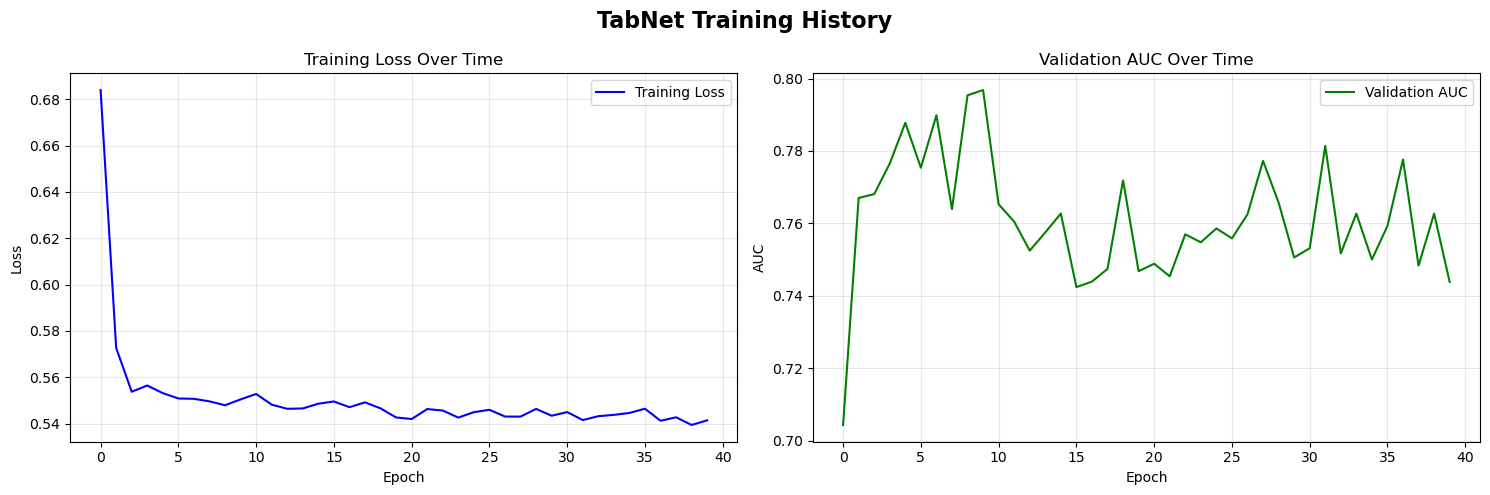

In [20]:
hist = tabnet.history

train_loss = hist['loss']
val_auc = hist['val_0_auc']

fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].plot(train_loss, label='Training Loss', color='blue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(val_auc, label='Validation AUC', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].set_title('Validation AUC Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('TabNet Training History', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [21]:
y_pred = tabnet.predict(x_test_pp)
y_pred_proba = tabnet.predict_proba(x_test_pp)[:,1]

print(f"Predicted class shape: {y_pred.shape}")
print(f"Predicted probabilities shape: {y_pred_proba.shape}")

Predicted class shape: (10500,)
Predicted probabilities shape: (10500,)


In [22]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc_score:.4f}")

Accuracy: 0.7275
Precision: 0.7333
Recall: 0.7147
F1-Score: 0.7239
AUC: 0.7920


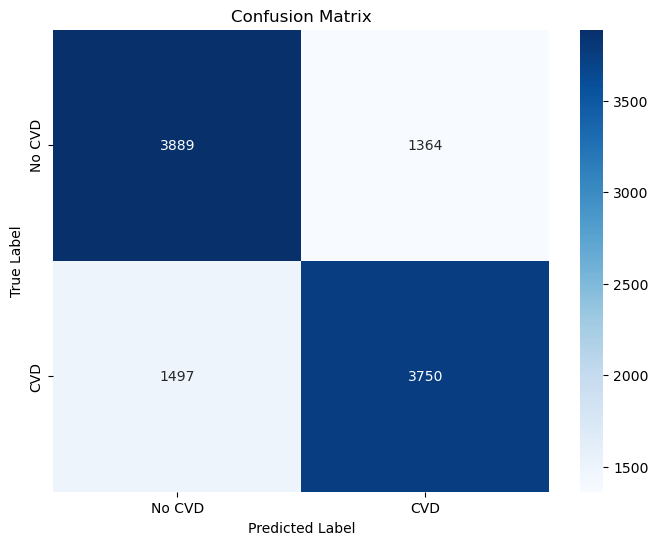

True Negatives: 3889
True Negatives:  3889
False Positives: 1364
False Negatives: 1497
True Positives:  3750

Specificity: 0.7403
Sensitivity (Recall): 0.7147


In [23]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No CVD', 'CVD'],
            yticklabels=['No CVD', 'CVD'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

tn, fp, fn, tp = cm.ravel()

print(f"True Negatives: {tn}")
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")

print(f"\nSpecificity: {tn/(tn+fp):.4f}")
print(f"Sensitivity (Recall): {tp/(tp+fn):.4f}")

In [24]:
print(classification_report(y_test, y_pred, 
                          target_names=['No CVD', 'CVD']))

              precision    recall  f1-score   support

      No CVD       0.72      0.74      0.73      5253
         CVD       0.73      0.71      0.72      5247

    accuracy                           0.73     10500
   macro avg       0.73      0.73      0.73     10500
weighted avg       0.73      0.73      0.73     10500



In [25]:
fi = tabnet.feature_importances_
print("Feature importances (TabNet):")
for name, imp in zip(ct.get_feature_names_out(), fi):
    print(f"{name}: {imp:.4f}")

M_explain, masks = tabnet.explain(x_val_pp)

top_idx = np.argsort(-M_explain[0])[:10]
print('top features for sample 0:')
for i in top_idx:
    print(ct.get_feature_names_out()[i], M_explain[0, i])

Feature importances (TabNet):
cont__height: 0.0045
cont__weight: 0.0188
cont__ap_hi: 0.3857
cont__ap_lo: 0.0010
cont__age_years: 0.1491
cont__pulse_pressure: 0.0069
cont__mean_arterial_pressure: 0.0053
cont__bp_ratio: 0.0000
cont__bmi: 0.0320
bin__gender: 0.1057
bin__cholesterol: 0.2278
bin__gluc: 0.0000
bin__smoke: 0.0048
bin__alco: 0.0003
bin__active: 0.0580
top features for sample 0:
cont__ap_hi 1.244970679283142
bin__cholesterol 0.30972760915756226
cont__age_years 0.30071836709976196
bin__gender 0.2364257127046585
bin__active 0.07195258885622025
cont__bmi 0.06378595530986786
cont__weight 0.04734092205762863
cont__height 0.0
cont__ap_lo 0.0
cont__pulse_pressure 0.0


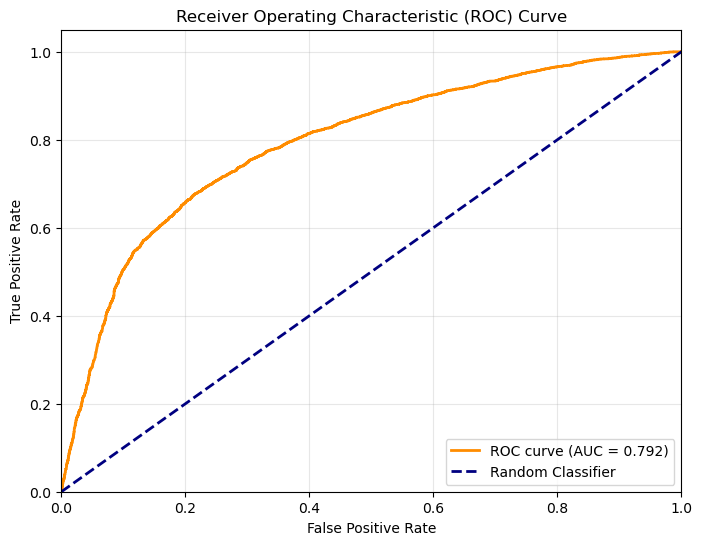

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [27]:
print(ct.get_feature_names_out())

['cont__height' 'cont__weight' 'cont__ap_hi' 'cont__ap_lo'
 'cont__age_years' 'cont__pulse_pressure' 'cont__mean_arterial_pressure'
 'cont__bp_ratio' 'cont__bmi' 'bin__gender' 'bin__cholesterol' 'bin__gluc'
 'bin__smoke' 'bin__alco' 'bin__active']


In [28]:
feature_columns = ct.get_feature_names_out()
feature_importance = tabnet.feature_importances_


importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("TabNet Feature Importance:")
print(importance_df)

TabNet Feature Importance:
                         feature  importance
2                    cont__ap_hi    0.385711
10              bin__cholesterol    0.227811
4                cont__age_years    0.149117
9                    bin__gender    0.105747
14                   bin__active    0.058022
8                      cont__bmi    0.031959
1                   cont__weight    0.018784
5           cont__pulse_pressure    0.006914
6   cont__mean_arterial_pressure    0.005292
12                    bin__smoke    0.004772
0                   cont__height    0.004536
3                    cont__ap_lo    0.000991
13                     bin__alco    0.000295
11                     bin__gluc    0.000025
7                 cont__bp_ratio    0.000023


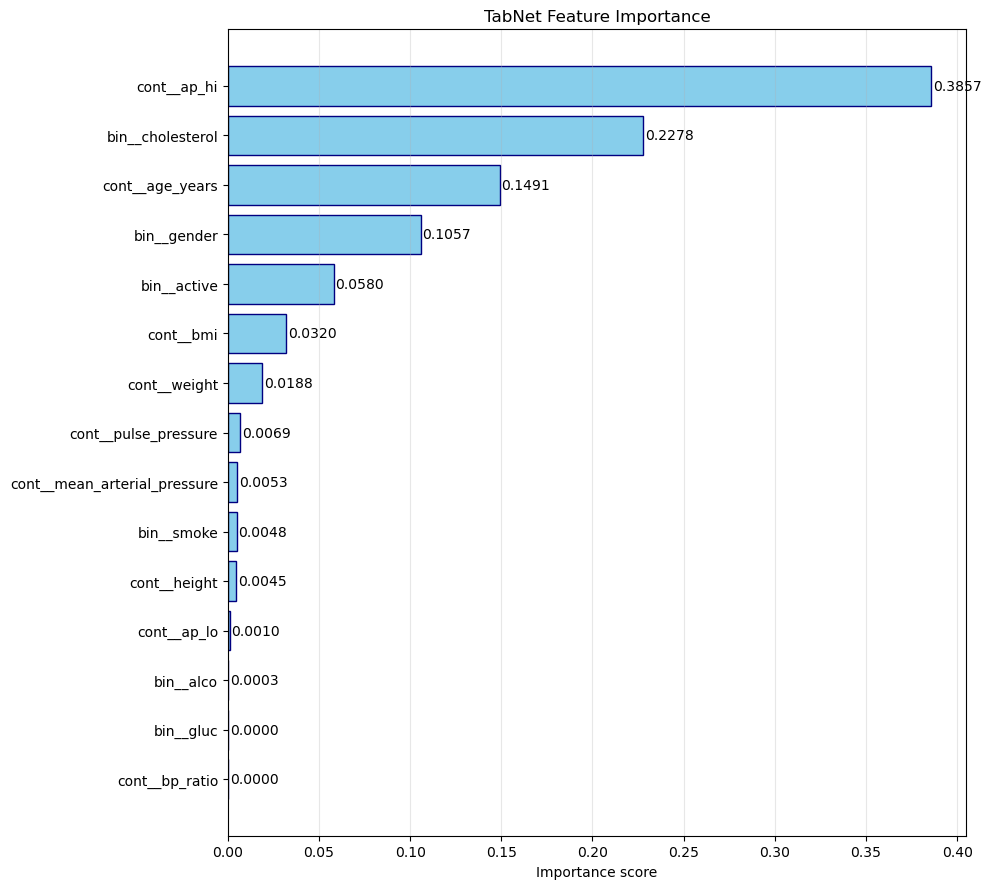

In [29]:
plt.figure(figsize=(10,9))
plt.barh(importance_df['feature'][::-1],
         importance_df['importance'][::-1],
         color = 'skyblue', edgecolor = 'navy')
plt.xlabel('Importance score')
plt.title('TabNet Feature Importance')
plt.grid(True, alpha = 0.3, axis = 'x')

for i, v in enumerate(importance_df['importance'][::-1]):
    plt.text(v + 0.001, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()

In [30]:
def tabnet_predict_proba(x):
    if isinstance(x, pd.DataFrame):
        x = x.values
    return tabnet.predict_proba(x)[:, 1]

b_samples = 100
b_idx = np.random.choice(len(x_train_pp), b_samples, replace=False)
b_data = x_train_pp[b_idx]

print(f"Background samples: {b_samples}")
print(f"Background data shape: {b_data.shape}")

Background samples: 100
Background data shape: (100, 15)


In [31]:
_, background_data, _, background_labels = train_test_split(
    x_train_pp, y_train_for_model, 
    test_size=min(200, len(x_train_pp)//10),  
    stratify=y_train_for_model,
    random_state=42
)

e = shap.KernelExplainer(tabnet_predict_proba, background_data)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [32]:
n_explain_samples = 200
X_explain = x_test_pp[:n_explain_samples]
y_explain = y_test[:n_explain_samples]
shap_values = e.shap_values(X_explain, nsamples = 100)

print(f"SHap values shape: {shap_values.shape}")


  0%|          | 0/200 [00:00<?, ?it/s]

SHap values shape: (200, 15)


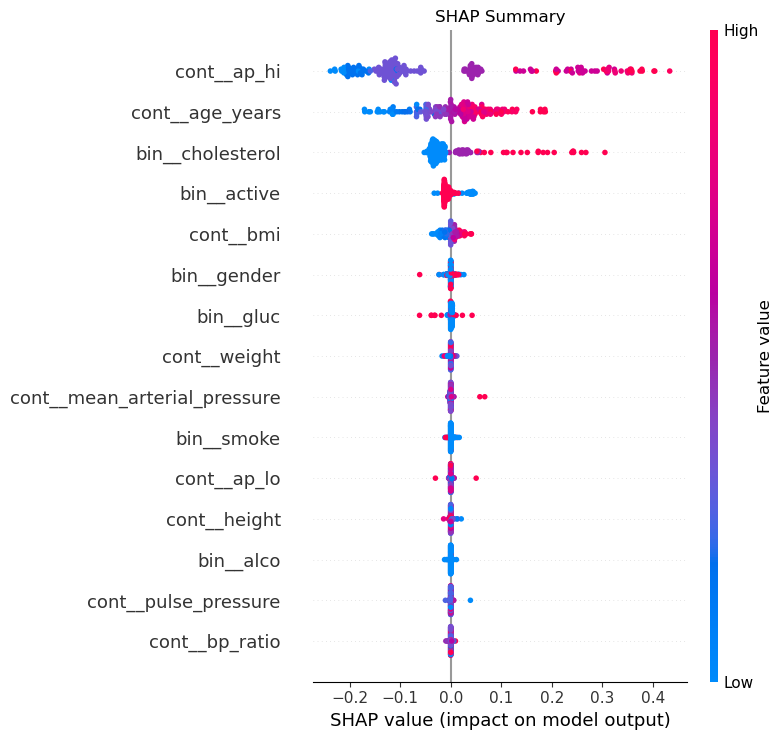

In [33]:
X_explain_df = pd.DataFrame(X_explain, columns = feature_columns)

plt.figure(figsize = (10,8))
shap.summary_plot(shap_values, X_explain_df, show=False)
plt.title("SHAP Summary")
plt.tight_layout()
plt.show()

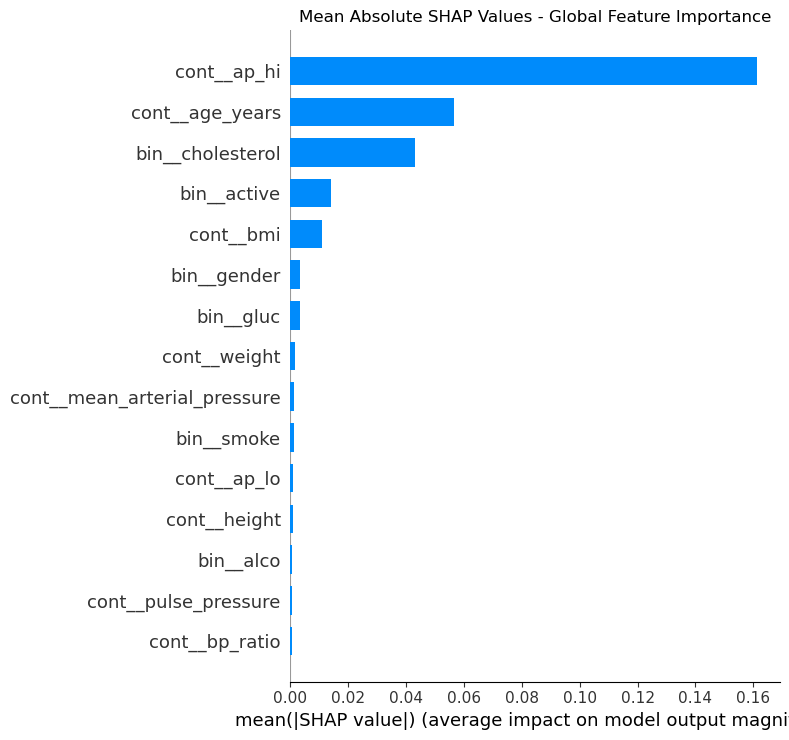

In [34]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_explain_df, plot_type="bar", show=False)
plt.title("Mean Absolute SHAP Values - Global Feature Importance")
plt.tight_layout()
plt.show()

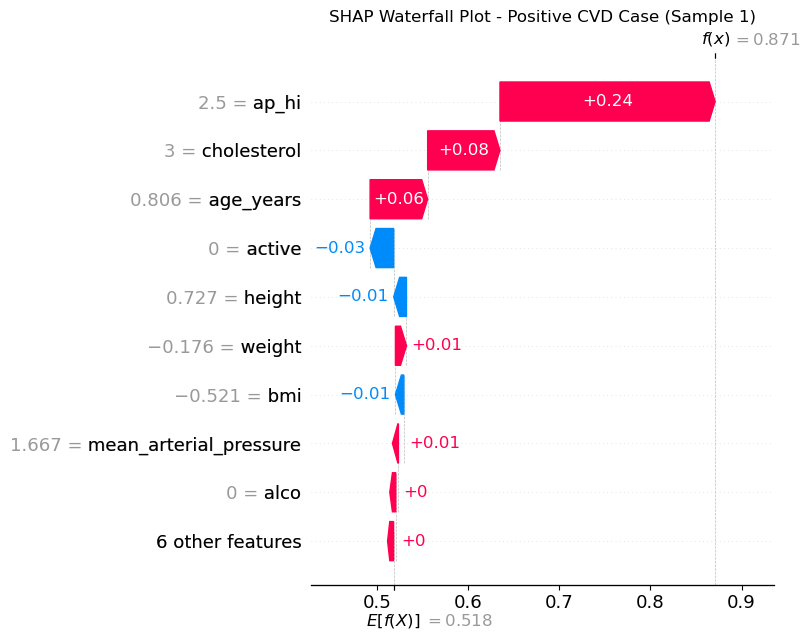

True label: CVD
Predicted probability: 0.871


In [35]:
feature_cols = continuous + binary_d
positive_indices = np.where(y_explain == 1)[0]
if len(positive_indices) > 0:
    positive_idx = positive_indices[0]
    
   
    shap_explanation = shap.Explanation(
        values = shap_values[positive_idx],
        base_values = e.expected_value,
        data = X_explain[positive_idx],
        feature_names = feature_cols
    )
    
    plt.figure(figsize= (12, 6))
    shap.waterfall_plot(shap_explanation, show =False)
    plt.title(f"SHAP Waterfall Plot - Positive CVD Case (Sample {positive_idx})")
    plt.tight_layout()
    plt.show()
    
    print(f"True label: CVD")
    print(f"Predicted probability: {tabnet_predict_proba(X_explain[positive_idx:positive_idx+1])[0]:.3f}")

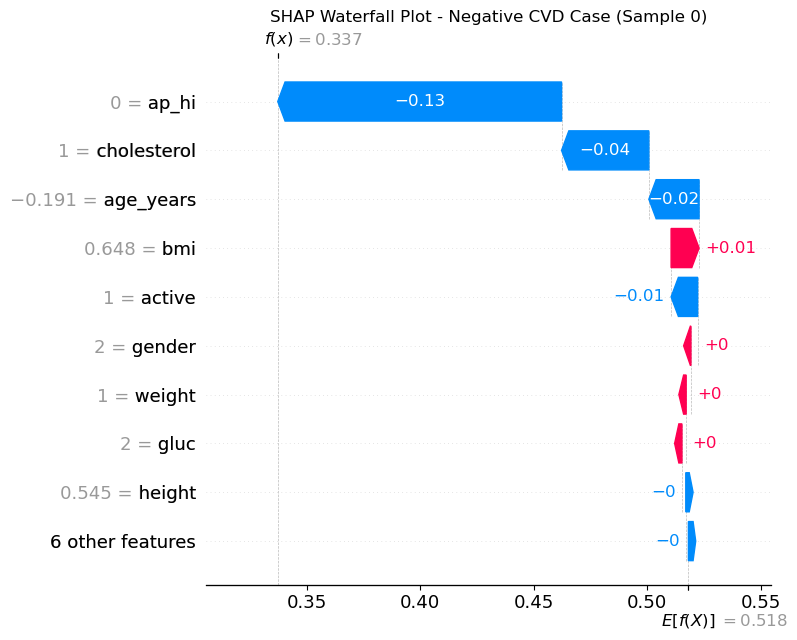

In [36]:
negative_indices = np.where(y_explain == 0)[0]
if len(negative_indices) > 0:
    negative_idx = negative_indices[0]
    
    
    shap_explanation = shap.Explanation(
        values=shap_values[negative_idx],
        base_values=e.expected_value,
        data=X_explain[negative_idx],
        feature_names=feature_cols
    )
    
    plt.figure(figsize=(12, 6))
    shap.waterfall_plot(shap_explanation, show=False)
    plt.title(f"SHAP Waterfall Plot - Negative CVD Case (Sample {negative_idx})")
    plt.tight_layout()
    plt.show()

In [37]:
#shap vs tabnet importance
shap_importance = np.mean(np.abs(shap_values), axis=0)

comparison_df = pd.DataFrame({
    'feature': feature_columns,
    'tabnet_importance': feature_importance,
    'shap_importance': shap_importance
})

comparison_df['tabnet_norm'] = comparison_df['tabnet_importance'] / comparison_df['tabnet_importance'].max()
comparison_df['shap_norm'] = comparison_df['shap_importance'] / comparison_df['shap_importance'].max()

comparison_df['avg_importance'] = (comparison_df['tabnet_norm'] + comparison_df['shap_norm']) / 2
comparison_df = comparison_df.sort_values('avg_importance', ascending=False)

print("Feature Importance Comparison (TabNet vs SHAP):")
print("="*60)
print(comparison_df[['feature', 'tabnet_norm', 'shap_norm']])

Feature Importance Comparison (TabNet vs SHAP):
                         feature  tabnet_norm  shap_norm
2                    cont__ap_hi     1.000000   1.000000
10              bin__cholesterol     0.590626   0.267513
4                cont__age_years     0.386602   0.350555
9                    bin__gender     0.274162   0.020881
14                   bin__active     0.150428   0.086839
8                      cont__bmi     0.082858   0.068355
1                   cont__weight     0.048701   0.010496
5           cont__pulse_pressure     0.017925   0.003823
6   cont__mean_arterial_pressure     0.013721   0.007536
11                     bin__gluc     0.000064   0.019516
12                    bin__smoke     0.012373   0.007096
0                   cont__height     0.011760   0.005621
3                    cont__ap_lo     0.002570   0.005809
13                     bin__alco     0.000765   0.004152
7                 cont__bp_ratio     0.000059   0.003522


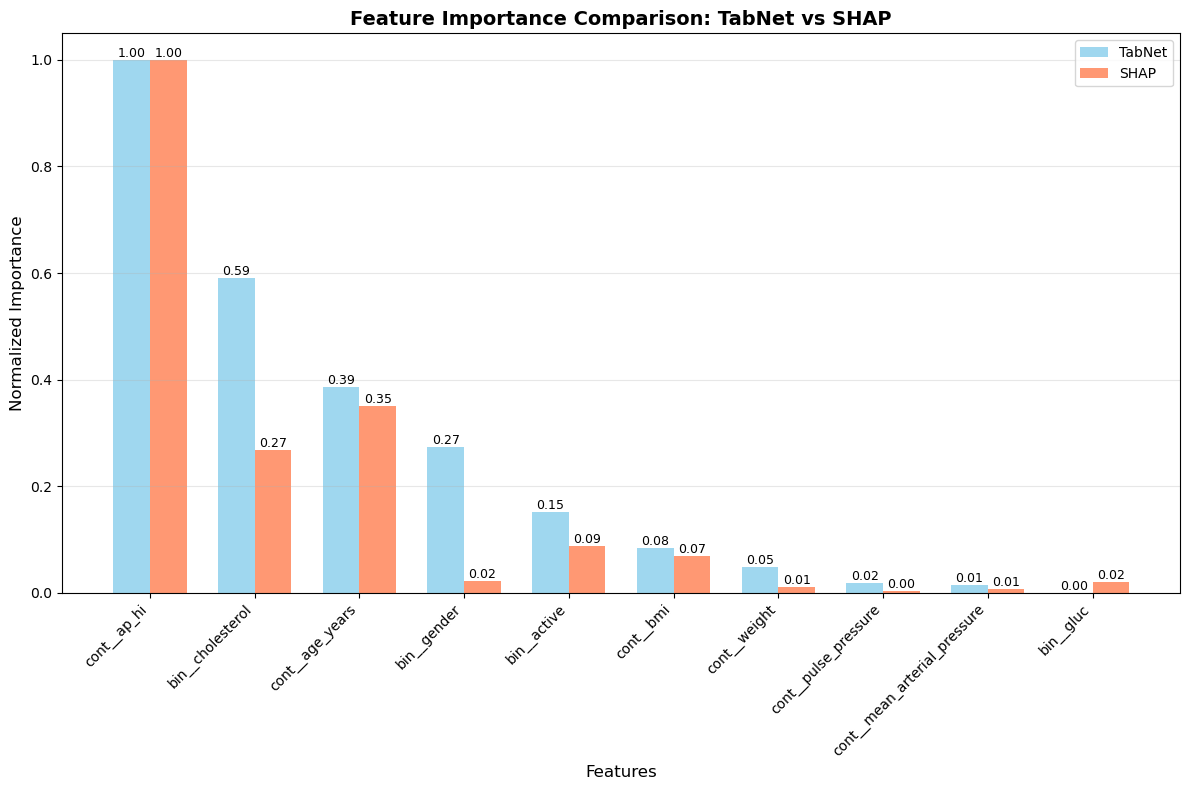

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))


features_to_plot = comparison_df.head(10)
x = np.arange(len(features_to_plot))
width = 0.35


bars1 = ax.bar(x - width/2, features_to_plot['tabnet_norm'], 
               width, label='TabNet', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, features_to_plot['shap_norm'], 
               width, label='SHAP', alpha=0.8, color='coral')


ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Normalized Importance', fontsize=12)
ax.set_title('Feature Importance Comparison: TabNet vs SHAP', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(features_to_plot['feature'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')


for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

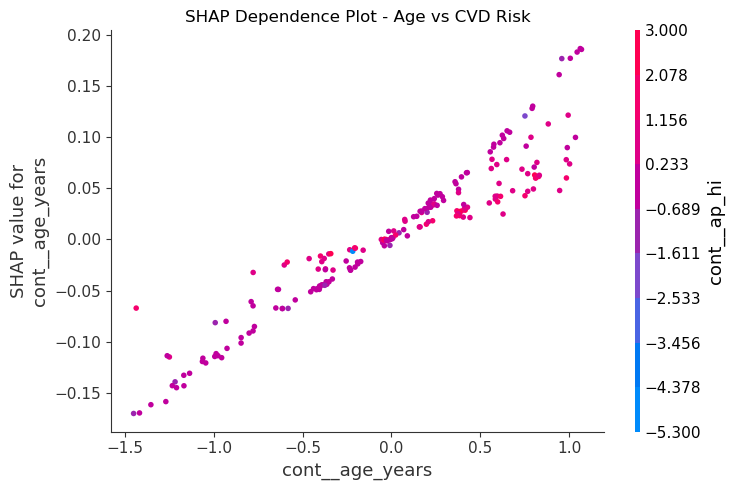

Age dependence analysis:
This plot shows how age affects CVD risk prediction.
Points are colored by the feature that most interacts with age.


In [39]:
#Age
shap.dependence_plot('cont__age_years', shap_values, X_explain_df, show=False)
plt.title('SHAP Dependence Plot - Age vs CVD Risk')
plt.tight_layout()
plt.show()

print("Age dependence analysis:")
print("This plot shows how age affects CVD risk prediction.")
print("Points are colored by the feature that most interacts with age.")

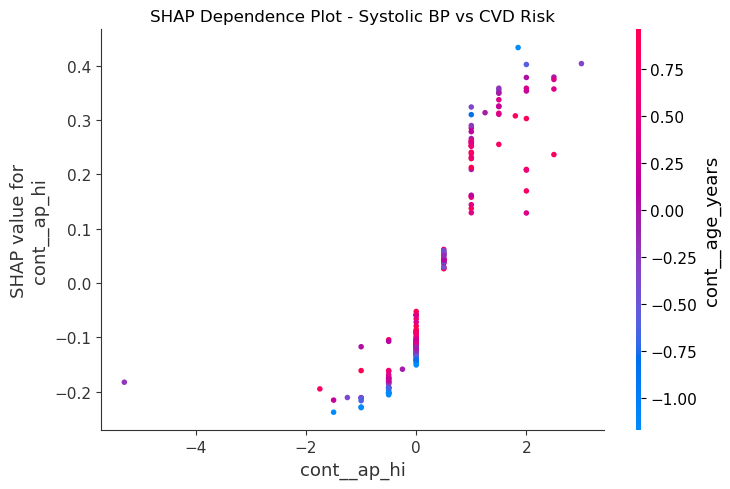

In [40]:
#systolic
shap.dependence_plot('cont__ap_hi', shap_values, X_explain_df, show=False)
plt.title('SHAP Dependence Plot - Systolic BP vs CVD Risk')
plt.tight_layout()
plt.show()


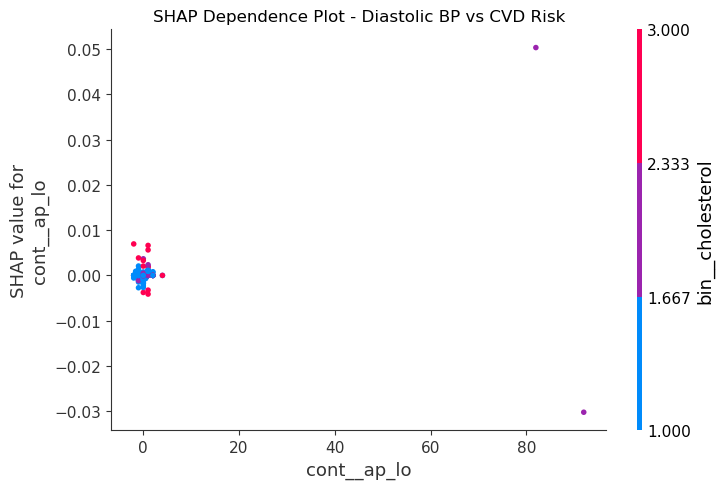

In [41]:
#diastolic
shap.dependence_plot('cont__ap_lo', shap_values, X_explain_df, show=False)
plt.title('SHAP Dependence Plot - Diastolic BP vs CVD Risk')
plt.tight_layout()
plt.show()


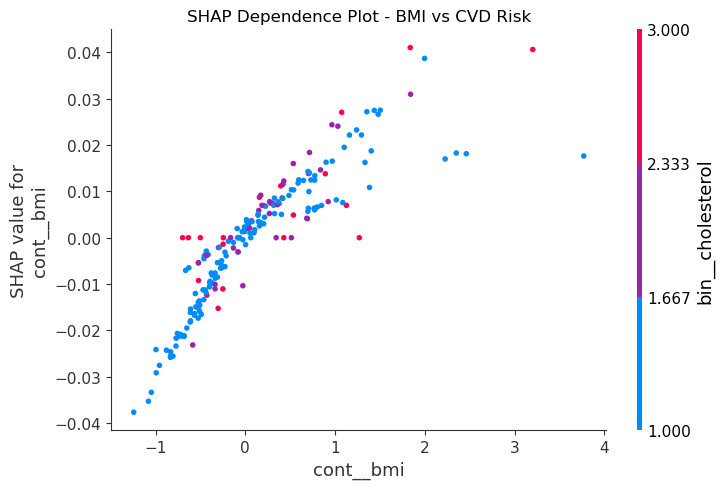

In [42]:
#BMI
shap.dependence_plot('cont__bmi', shap_values, X_explain_df, show=False)
plt.title('SHAP Dependence Plot - BMI vs CVD Risk')
plt.tight_layout()
plt.show()